# Experimental analysis

## Setup

In [1]:
%matplotlib inline
import os
import csv
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

from random import sample
from scipy.stats import ttest_rel
from IPython.display import display, HTML

### MATPLOTLIB CONFS
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

pl.rc('font', size=BIGGER_SIZE)          # controls default text sizes
pl.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
pl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
pl.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
pl.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
pl.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
pl.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Utility Functions

In [2]:
# Functions
def dcg(relevances, rank=10):
    """Discounted cumulative gain at rank (DCG)"""
    relevances = np.asarray(relevances)[:rank]
    n_relevances = len(relevances)
    if n_relevances == 0:
        return 0.

    discounts = np.log2(np.arange(n_relevances) + 2)
    return np.sum(relevances / discounts)
 
 
def ndcg(relevances, rank=10, perfect=None):
    """Normalized discounted cumulative gain (NDGC)"""
    if perfect is None:
        perfect = sorted(relevances, reverse=True)
    best_dcg = dcg(perfect, rank)
    if best_dcg == 0:
        return 0.

    return dcg(relevances, rank) / best_dcg

## Load Data

In [3]:
# Load cleaned data
## Getting the current work directory (cwd)
thisdir = os.getcwd()

## Finding data files
data_files = [f for f in os.listdir("{}/clean".format(thisdir))]
file_contents = {}
for fl in data_files:
    fpath = "{}/clean/{}".format(thisdir,fl)
    fkey = fl.split('.')[0]
    fdelim = None
    if '.tsv' in fl:
        fdelim = '\t'
    if '.csv' in fl:
        fdelim = ';'
        
        
    if fdelim is None:
        print("Skipped {}".format(fl))
    else:
        file_contents[fkey] = list(csv.reader(open(fpath, 'r'), delimiter=fdelim))
    

print('Loaded {} files'.format(len(file_contents)))
for k,v in file_contents.items():
    print('{} : {} lines'.format(k, len(v)))

Skipped .ipynb_checkpoints
Loaded 6 files
us3-answers : 1244 lines
us2-answers : 1183 lines
us1-method-rankings : 151 lines
us3-method-rankings : 121 lines
us2-method-rankings : 121 lines
us1-answers : 1168 lines


## Prepare Data

> This post-process and translates the tabular  in dictionaries and lists necessary to compute the final statistics

In [4]:
answers ={ # each row is a nested dictionary: QueryID > AnswerID > Score (each answer has assigned 1 final score)
  '1 Entity':  {},  
  '1 Edge': {},
  '2+ Edges':  {}
}

file_pairings = [('1 Entity', 'us1-answers'), 
            ('1 Edge', 'us2-answers'),
            ('2+ Edges', 'us3-answers')
           ]

for p in file_pairings:
    for rw in file_contents[p[1]][1:]:
        qkey = rw[0].lower().replace(' ','')
        anskey = rw[1].lower().replace(' ', '')
        d = answers[p[0]].setdefault(qkey, {})
        d[anskey]= m.ceil(float(rw[2])) # make them integer


        
rankings ={ # each row is a nested dictionary: MethodName >  QueryID >  [ rankings ...]  as list of scores retrieved from the `answers` dic
  '1 Entity':  {},  
  '1 Edge': {},
  '2+ Edges':  {}
}

file_pairings = [('1 Entity', 'us1-method-rankings'), 
            ('1 Edge', 'us2-method-rankings'),
            ('2+ Edges', 'us3-method-rankings')
           ]

for p in file_pairings:
    scores = answers[p[0]]
    print('\n', p[1])
    for rw in file_contents[p[1]][1:]:
        d = rankings[p[0]].setdefault(rw[0], {})
        
        qkey=rw[1].lower().replace(' ','')        
        query_scores = scores[qkey]
        try:
            d[rw[1]]= [ query_scores[x.lower().replace(' ', '')] for x in rw[2:] if x is not None ]
        except Exception as e:
            print(e,'\n',rw[0],'\n',rw[1])
            break



 us1-method-rankings

 us2-method-rankings

 us3-method-rankings


## Plot Figures

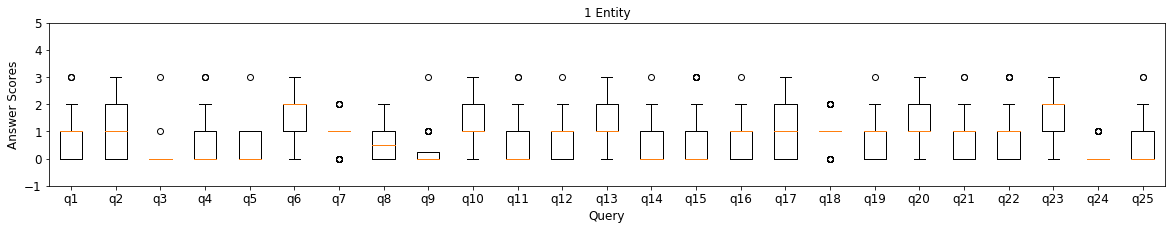

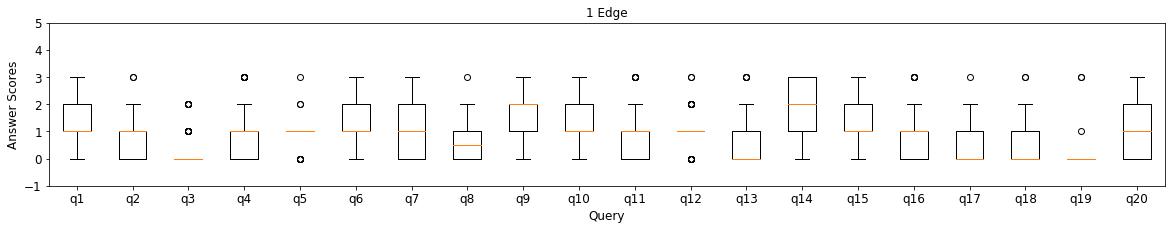

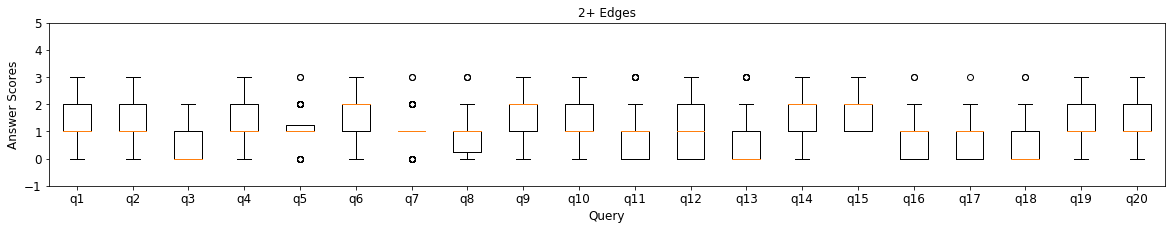

In [18]:
for group, anss in answers.items(): ## We have 3 experiments: '1 Entity', '1 Edge', and '2+ Edges' -> so we plot 3 figure
    q_scores = []
    q_ids = []
    ## for each query aggregate data of all the scores of each answer
    _id=0
    for qid , scores in anss.items():
        _id+=1
        q_ids.append("q{}".format(_id))
        q_scores.append(list(scores.values()))
        
        
    ## Figure
    fig=pl.figure(figsize=(20,3))
    ax1=fig.add_subplot(111) 
    pl.setp(ax1.get_xticklabels(), visible=True)
    axes = pl.gca()
    axes.set_ylim(-1,5)
    ## 
        
    ax1.set_title(group)
    ax1.boxplot(q_scores)
    pl.xticks(range(1,len(q_ids)+1), q_ids, size=12)    
    pl.xlabel("Query")
    pl.ylabel("Answer Scores")

    pl.savefig('figs/answer-scores-{}.pdf'.format(group.replace(' ','').replace('+','')), bbox_inches="tight")


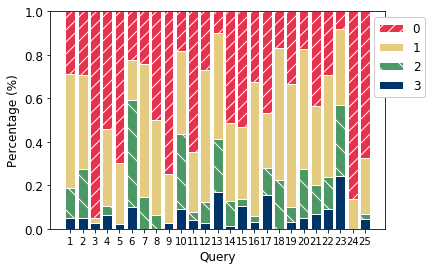

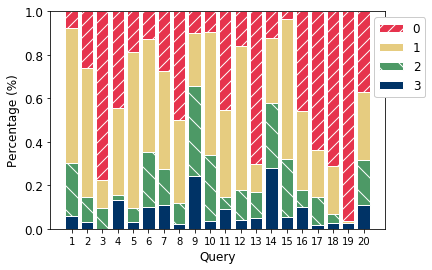

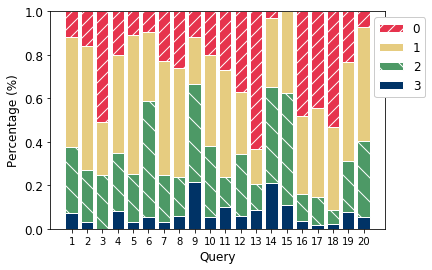

In [5]:
# Find optimal ranking for the NDCG

optimal_rankings = {
    # MethodName> QueryID> [ optimal ranking ]
}

for group, anss in answers.items():  ## We have 3 experiments: '1 Entity', '1 Edge', and '2+ Edges' -> so we plot 3 figures
    temp = {}
    # QueryID > AnswerID > final rating
    for qid , scores in anss.items():
        temp[qid] = [ s for s in scores.values()]
        temp[qid].sort(reverse=True)

        optimal_rankings[group] = temp

    ## Figure
    fig=pl.figure()
    ax1=fig.add_subplot(111) 
    pl.setp(ax1.get_xticklabels(), visible=True)
    axes = pl.gca()
    axes.set_ylim(0,1)
    ## 

    plts = []
    nq = len(temp)
    indx = range(1,nq+1)
    percs = {}
    bottoms = []
    
    ## Stripe filling
    fill = [ ('white', '//' , (0.9, 0.2, 0.3)), 
            ('white', ' ',(0.9, 0.8, 0.5)), 
            ('white', '\\', (0.3, 0.6, 0.4)), 
            ('white', '', (0.0, 0.2, 0.4)) ]
    
    
    for r in range(3,-1,-1):        
        percs[r] =[] 
        for qk, ans in temp.items():
            score = len([x for x in ans if x == r])/len(ans)
            percs[r].append(score)
        if len(bottoms) == 0:
            p = pl.bar(indx, percs[r], align='center', 
                       color=fill[r][2],                       
                       edgecolor=fill[r][0], hatch=fill[r][1]
                      )
            bottoms= percs[r].copy()
        else:
            p = pl.bar(indx, percs[r], align='center', bottom=bottoms, 
                       color=fill[r][2],
                       edgecolor=fill[r][0], hatch=fill[r][1]                       
                       )
            bottoms = [x[0]+x[1] for x in zip(percs[r], bottoms)  ]
        plts.append(p)

    pl.xticks(indx, indx)
    pl.xticks(indx, indx,size=10)  
    pl.xlabel("Query")
    pl.ylabel("Percentage (%)")
    lg = pl.legend([p[0] for p in plts[::-1]], range(0,4), bbox_to_anchor=(0.95,1), 
                   loc="upper left", framealpha=1)
    lg.get_frame().set_facecolor('#FFFFFF')

    #_ = pl.title("Percentage of Answer scores for Query with {}".format(group)) 
    pl.savefig('figs/answer-scores-{}.pdf'.format(group.replace(' ','').replace('+','')), bbox_inches="tight")
        

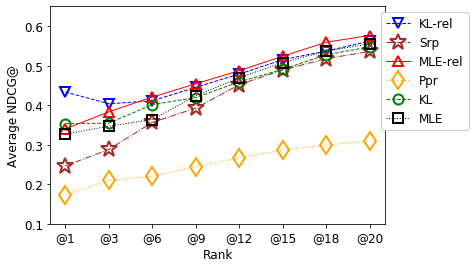

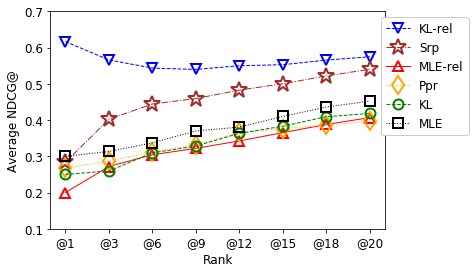

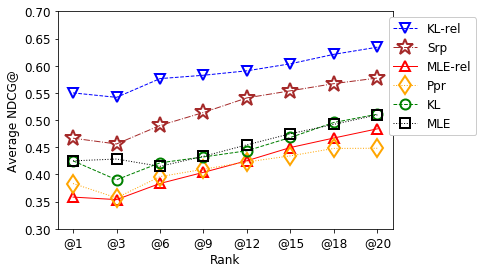

In [6]:
# Variation of NDCG score at top-1,..., top-20 when the starting query is 1 Entity
# Variation of NDCG score at top-1,..., and top-20 when the starting query is 1 Edge (2 Entities)
# Variation of NDCG score at top-1,..., and top-20 when the starting query is 2 or more Edges (3+ Entities)


groups = [ '1 Entity', '1 Edge', '2+ Edges']
ticks  = [ 1, 3, 6, 9, 12, 15, 18, 20 ]
tick_labels = ['@{}'.format(i) for i in ticks]
ndcgs = {
    # Group> Method > tick `; score
}

legend = {'kl':  ('--v', 10,'b', 'KL-rel'),
          'em':  ('-^',10,'r', 'MLE-rel'),
          'kll': ('--o',10,'g', 'KL'),
          'eml': (':s',10,'k', 'MLE'),
          'ppr': (':d',13,'orange', 'Ppr'),
          'srp': ('-.*',17,'brown', 'Srp')}


groups_lims = { '1 Entity': [0.1, 0.65] , 
                '1 Edge':  [0.1, 0.7], 
                '2+ Edges': [0.3, 0.7]  
              }
method_order = ['kl', 'srp', 'em', 'ppr', 'kll', 'eml']

# calculate AVG NDCG for each methods for each group and plot!
for group, y_lim in groups_lims.items():
    #    Method >  Query >  rankins as list of scores 
    ndcgs[group]= {}
    optimals = optimal_rankings[group]
    
    ## Figure
    fig=pl.figure()
    ax1=fig.add_subplot(111) 
    pl.setp(ax1.get_xticklabels(), visible=True)
    axes = pl.gca()
    axes.set_ylim(y_lim)
    ## 
    
    
    ordered_queries = sorted([q for q in optimals.keys()])    
    for m in method_order:
        queries = rankings[group][m]
        ndcgs[group][m]=[]
        for tick in ticks:
            tmp_ndcg = []
            try:
                for qid in ordered_queries:
                    ranking = queries[qid]
                    tmp_ndcg.append(ndcg(ranking, rank=tick, perfect=optimals[qid]))

                ndcgs[group][m].append(tmp_ndcg)
            except Exception as e:
                print(group, m, e)
                
        pl.plot([sum(t)/len(t) for t in ndcgs[group][m]],
                legend[m][0],lw=1,mew=2, ms=legend[m][1],color=legend[m][2], 
                 markerfacecolor='none',label=legend[m][3])

    
        pl.xticks(range(len(ticks)), tick_labels, size=12)    
        pl.xlabel("Rank")
        pl.ylabel("Average NDCG@")
        #plt.legend(loc='best')
        pl.legend(bbox_to_anchor=(0.97,1), loc="upper left", framealpha=1)
        #_ = pl.title("NDCG with {}".format(group)) 
        pl.savefig('figs/ndgc-{}.pdf'.format(group.replace(' ','').replace('+','')), bbox_inches="tight")

        
    # Compute confidence intervals and statistical significance!
    for t in range(0, len(ticks)):
        ttests = {}
        for m1 in range(0, len(method_order)-2):
            m1l = method_order[m1]
            ttests[m1l] = {}
            for m2 in range(m1+1, len(method_order)):
                m2l = method_order[m2]

                stat, p = ttest_rel(ndcgs[group][m1l][t],ndcgs[group][m2l][t])
                #print(method_order[m1],method_order[m2],stat,p)
                #print('Statistics for {}, {} = {:.3f}, p {:.3f}'.format(method_order[m1],method_order[m2],stat,p))                
                if p > 0.05:
                    ttests[m1l][m2l] = 'X'
                    #print('Fail for {} {} vs. {} at{}'.format(group, method_order[m1],method_order[m2], t))
                else:
                    ttests[m1l][m2l] = p
                    
        #display(HTML('<h4>@{} ({})</h4>'.format(ticks[t], group)))
        #df = pd.DataFrame(data=ttests)
        #df.replace(np.nan, '', inplace=True)
        #display(HTML(df.to_html()))